In [1]:
pip install scikeras

     ---------------------------------------- 0.0/48.7 kB ? eta -:--:--
     -------- ------------------------------- 10.2/48.7 kB ? eta -:--:--
     ------------------------------- ------ 41.0/48.7 kB 653.6 kB/s eta 0:00:01
     -------------------------------------- 48.7/48.7 kB 610.7 kB/s eta 0:00:00
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ----- ---------------------------------- 0.2/1.2 MB 5.3 MB/s eta 0:00:01
   ------------------------ --------------- 0.7/1.2 MB 9.5 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 9.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/133.7 kB ? eta -:--:--
   ---------------------------------------- 133.7/133.7 kB 8.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
   ---------------------------- ----------- 2.1/3.0 MB 68.4 MB/s eta 0:00:01
   ---------------------------------------  3.0/3.0 MB 48.1 MB/s eta 0:00:01
   ---------------------

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import explained_variance_score
import plotly.express as px
from typing import Tuple, List, Any
import matplotlib as mpl
import warnings
import os
from tensorflow.keras.layers import LSTM, SimpleRNN
import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
import json

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

ModuleNotFoundError: No module named 'tensorflow'

## Funciones para el Entrenamiento

In [3]:
train_data = pd.read_csv('/content/train u1.txt', delimiter=';')
train_data.head()

,time index,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z
0,1,-9.665799,-1.677241,0.615063,-0.014956,0.004388,0.010589,0.587318,0.455106,-0.094949
1,2,-9.665806,-1.684737,0.622513,0.000607,-0.003094,-0.007589,0.587428,0.455621,-0.093364
2,3,-9.628410,-1.699724,0.585751,0.006007,0.000557,-0.004879,0.588389,0.454722,-0.094907
3,4,-9.628372,-1.684836,0.600733,-0.003085,-0.000281,-0.000340,0.588673,0.455759,-0.092664
4,5,-9.643291,-1.639893,0.585661,-0.002932,-0.006807,-0.013043,0.589193,0.453927,-0.093143


Instanciamos los modelos de MLP, RNN y LSTM que estaremos usando.

In [5]:
def create_mlp(input_dim, neurons, dropout_rate):
    model = Sequential([
        Dense(neurons, activation='relu', input_dim=input_dim),
        Dropout(dropout_rate),
        Dense(neurons // 2, activation='relu'),
        Dropout(dropout_rate / 2),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model


def create_rnn(input_shape, neurons, dropout_rate):
    model = Sequential([
        SimpleRNN(neurons, activation='relu', input_shape=input_shape, return_sequences=False),
        Dropout(dropout_rate),
        Dense(neurons // 2, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model


def create_lstm(input_shape, neurons, dropout_rate):
    model = Sequential([
        LSTM(neurons, activation='tanh', input_shape=input_shape, return_sequences=False),
        Dropout(dropout_rate),
        Dense(neurons // 2, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model


Este código define una función para crear envolturas de modelos de aprendizaje profundo (MLP, RNN o LSTM), adaptando los datos de entrada según el tipo de modelo. Si es un MLP, verifica que los datos sean 2D; si es RNN/LSTM, ajusta los datos a una estructura 3D con ventanas de tiempo (timesteps). Finalmente, devuelve un KerasRegressor configurado para el modelo seleccionado, con parámetros como número de neuronas y tasa de dropout.



In [6]:
def create_model_wrapper(create_model, model_name, xtrain, ytrain, neurons, dropout_rate, timesteps, **kwargs):

    def reshape_to_timesteps(x, y, timesteps):
        if len(x) < timesteps:
            raise ValueError(f"Insuficientes datos para crear ventanas con {timesteps} pasos.")
        X_reshaped, y_reshaped = [], []
        for i in range(len(x) - timesteps):
            X_reshaped.append(x[i:i + timesteps])
            y_reshaped.append(y[i + timesteps])
        return np.array(X_reshaped), np.array(y_reshaped)

    # Para MLP
    if model_name == "mlp":
        if len(xtrain.shape) != 2:
            raise ValueError(f"Unsupported input shape {xtrain.shape} for MLP. Expected 2D data.")
        input_dim = xtrain.shape[1]
        return KerasRegressor(
            model=create_model,
            input_dim=input_dim,
            neurons=neurons,
            dropout_rate=dropout_rate,
            **kwargs
        )

    # Para RNN y LSTM
    elif model_name in ["rnn", "lstm"]:
        try:
            if len(xtrain.shape) != 3:
                if len(xtrain.shape) == 2:
                    xtrain, ytrain = reshape_to_timesteps(xtrain, ytrain, timesteps)
                else:
                    raise ValueError(f"Unsupported input shape {xtrain.shape} for {model_name}. Expected 2D or 3D data.")
        except ValueError as e:
            print(f"Error al redimensionar los datos: {e}")
            return None

        input_shape = (xtrain.shape[1], xtrain.shape[2])
        model_creator = create_rnn if model_name == "rnn" else create_lstm

        return KerasRegressor(
            model=model_creator,
            input_shape=input_shape,
            neurons=neurons,
            dropout_rate=dropout_rate,
            **kwargs
        )
    else:
        raise ValueError(f"Model {model_name} is not supported.")


Este código implementa un flujo completo para el entrenamiento, evaluación y selección del mejor modelo basado en las configuraciones de hiperparámetros.

- Clase Data: Prepara los datos para modelos de aprendizaje profundo (MLP, RNN o LSTM). Convierte los datos en ventanas temporales (si son RNN/LSTM) o los mantiene en 2D (para MLP), y divide los datos en conjuntos de entrenamiento y prueba.

Funciones auxiliares:

- return_of_df: Crea una instancia de la clase Data con los datos proporcionados.

- calcular_metricas: Calcula métricas de rendimiento como RMSE, MAPE, R2 y pruebas estadísticas (Ljung-Box y Jarque-Bera) para evaluar la calidad del modelo.

- train_and_evaluate: Entrena y evalúa modelos iterando sobre combinaciones de hiperparámetros como la cantidad de neuronas, tasa de dropout y horizontes de tiempo. Divide los datos en ventanas de tiempo según el horizonte t.
Crea el modelo correspondiente (MLP, RNN o LSTM) usando create_model_wrapper.
Evalúa cada modelo en la ventana actual y almacena los resultados. Si un modelo supera la puntuación R2 más alta, lo guarda como el mejor modelo.

- training: Función principal que llama a train_and_evaluate con configuraciones específicas para cada tipo de modelo (mlp, rnn o lstm). Define un espacio de hiperparámetros (meta_param_grid) y selecciona el modelo a entrenar en función de su tipo.

In [7]:
class Data:
    def __init__(self, file, t, target, model_type):
        """
        Inicializa los datos para entrenamiento y prueba.
        - file: DataFrame con los datos.
        - t: Número de pasos temporales.
        - target: Nombre de la columna objetivo.
        - model_type: Tipo de modelo ("rnn", "lstm", "mlp").
        """
        t = t * 25
        file = (file.sort_values(by='time index')).reset_index(drop=True)

        if model_type in ["rnn", "lstm"]:
            self.X_train, self.y_train = self.reshape_to_timesteps(
                file.drop(target, axis='columns').iloc[:-t].values,
                file[target].iloc[:-t].values,
                t
            )
            self.X_test, self.y_test = self.reshape_to_timesteps(
                file.drop(target, axis='columns').iloc[-t:].values,
                file[target].iloc[-t:].values,
                t
            )
        elif model_type == "mlp":
            self.X_train = file.drop(target, axis='columns').iloc[:-t].values
            self.y_train = file[target].iloc[:-t].values
            self.X_test = file.drop(target, axis='columns').iloc[-t:].values
            self.y_test = file[target].iloc[-t:].values
        else:
            raise ValueError(f"Unsupported model type: {model_type}")

    @staticmethod
    def reshape_to_timesteps(x, y, timesteps):
        """
        Genera ventanas temporales para datos 3D.
        - x: Matriz de características (2D).
        - y: Vector objetivo.
        - timesteps: Número de pasos temporales.
        """
        X_reshaped, y_reshaped = [], []
        for i in range(len(x) - timesteps):
            X_reshaped.append(x[i:i + timesteps])
            y_reshaped.append(y[i + timesteps])

        return np.array(X_reshaped), np.array(y_reshaped)

def return_of_df(completed_df, t, model_name, target='mag_y'):
    return Data(completed_df, t, target, model_name)

def calcular_metricas(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if len(y_true) != len(y_pred):
        raise ValueError("y_true y y_pred deben tener el mismo tamaño.")

    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

    if np.any(y_true == 0):
        mape = np.inf
    else:
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

    try:
        lb_test = acorr_ljungbox(y_true - y_pred, lags=[10], return_df=True)
        ljung_box_pvalue = lb_test['lb_pvalue'].iloc[0]
    except Exception as e:
        ljung_box_pvalue = np.nan
    try:
        jb_test = jarque_bera(y_true - y_pred)
        jarque_bera_pvalue = jb_test[1]
    except Exception as e:
        jarque_bera_pvalue = np.nan

    return {
        'RMSE': [rmse],
        'MAPE': [mape],
        'R2': [r2],
        'Ljung-Box p-value': [ljung_box_pvalue],
        'Jarque-Bera p-value': [jarque_bera_pvalue]
    }

def train_and_evaluate(create_model, param_grid, train_data, model_name):
    best_model = None
    best_params = None
    best_score = -np.inf

    for dropout in param_grid['dropout']:
        for neurons in param_grid['neurons']:
            for t in [7, 14, 21, 28]:
                print(f"\n--- Entrenando para horizonte: {t} ---")

                try:
                    data = return_of_df(train_data, t, model_name.lower())
                except Exception as e:
                    print(f"Error al preparar los datos para horizonte {t}: {e}")
                    continue

                r2s_list = []
                t_window = t * 20

                for index in range(0, len(data.X_train), t_window):
                    try:
                        # Obtener los datos de la ventana
                        xtrain = data.X_train[index:index + t_window]
                        ytrain = data.y_train[index:index + t_window]

                        if len(xtrain) < t:
                            print(f"Ventana {index} no tiene suficientes datos. Saltando...")
                            continue

                        # Crear el modelo
                        model = create_model_wrapper(
                            create_model=create_model,
                            model_name=model_name.lower(),
                            xtrain=xtrain,
                            ytrain=ytrain,
                            neurons=neurons,
                            dropout_rate=dropout,
                            timesteps=t,
                            epochs=10,
                            verbose=1
                        )

                        # Entrenar el modelo
                        if model_name == "mlp":
                            pipeline = Pipeline([('scaler', StandardScaler()), (model_name.lower(), model)])
                        else:
                            pipeline = Pipeline([(model_name.lower(), model)])

                        pipeline.fit(xtrain, ytrain)

                        print(f"Ventana {index}: entrenamiento completado con Neuronas={neurons}, Dropout={dropout}")

                    except Exception as e:
                        print(f"Error durante el entrenamiento en ventana {index}: {e}")
                        continue

                    if len(data.X_test.shape) == 1:
                        data.X_test = data.X_test.reshape(-1, 1)

                    predictions = pipeline.predict(data.X_test)
                    r2 = r2_score(data.y_test, predictions)
                    r2s_list.append(r2)

                    metrics = calcular_metricas(data.y_test, predictions)

                    mean_r2 = np.mean(r2s_list) if r2s_list else -np.inf
                    if mean_r2 > best_score:
                        best_score = mean_r2
                        best_model = pipeline
                        best_params = {
                            'X_test': data.X_test,
                            'y_test': data.y_test,
                            'metricas': metrics,
                            'dropout': dropout,
                            'neurons': neurons
                        }


    if best_model and best_params:
        try:
            save_best_model(model_name, best_model, best_params, best_score)
        except Exception as e:
            print(f"Error al guardar el mejor modelo: {e}")

    return best_model, best_params, best_score


def training(model_name, train_data):
    meta_param_grid = { #añadir 0.4 y 100
        'mlp': {'dropout': [0.2, 0.4], 'neurons': [10, 100], 'batchsize': [16, 32]},
        'rnn': {'dropout': [0.2, 0.4], 'neurons': [10, 100], 'batchsize': [16, 32]},
        'lstm': {'dropout': [0.2, 0.4], 'neurons': [10, 100], 'batchsize': [16, 32]}
    }

    if model_name == 'mlp':
        return train_and_evaluate(create_mlp, meta_param_grid['mlp'], train_data, 'mlp')
    elif model_name == 'rnn':
        return train_and_evaluate(create_rnn, meta_param_grid['rnn'], train_data, 'rnn')
    elif model_name == 'lstm':
        return train_and_evaluate(create_lstm, meta_param_grid['lstm'], train_data, 'lstm')
    else:
        raise ValueError(f"Model {model_name} is not supported.")


## Entrenamiento de los Modelos

In [8]:
OUTPUT_DIR = "/content/Deep Learning"

def save_best_model(model_name, best_model, best_params, best_score):
    try:
        os.makedirs(OUTPUT_DIR, exist_ok=True)

        file_path = os.path.join(OUTPUT_DIR, f"best_model_{model_name}.json")

        results = {
            'model_name': model_name,
            'best_score': best_score,
            'best_params': {
                'dropout': best_params['dropout'],
                'neurons': best_params['neurons']
            },
            'metrics': best_params['metricas']
        }

        with open(file_path, 'w') as f:
            json.dump(results, f, indent=4)

        print(f"Resultados del mejor modelo guardados en {file_path}")

    except Exception as e:
        print(f"Error al guardar el mejor modelo: {e}")

def run_training_and_save():
    model_types = ['mlp', 'rnn', 'lstm']

    for model_type in model_types:
        print(f"\n--- Entrenando modelo: {model_type} ---")
        try:
            best_model, best_params, best_score = training(model_type, train_data)

            if best_model is not None and best_params is not None:
                print(f"Entrenamiento exitoso para {model_type}. Mejor puntaje: {best_score}")
            else:
                print(f"No se encontró un modelo válido para {model_type}")

        except Exception as ex:
            print(f"Error durante el entrenamiento del modelo {model_type}: {ex}")


run_training_and_save()



--- Entrenando modelo: mlp ---

--- Entrenando para horizonte: 7 ---
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 454ms/step - loss: 0.7563 - mean_squared_error: 0.7563
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6979 - mean_squared_error: 0.6979 
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4829 - mean_squared_error: 0.4829 
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5278 - mean_squared_error: 0.5278 
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3820 - mean_squared_error: 0.3820 
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3057 - mean_squared_error: 0.3057 
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3302 - mean_squared_error: 0.3302 
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2984 - mean_squared_error: 0.2984 
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2472 - mean_squared_error: 0.2472 
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3300 - mean_squared_error: 0.3300

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 365ms/step - loss: 0.5704 - mean_squared_error: 0.5704
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5365 - mean_squared_error: 0.5365 
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5061 - mean_squared_error: 0.5061 
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4384 - mean_squared_error: 0.4384 
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3779 - mean_squared_error: 0.3779 
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3978 - mean_squared_error: 0.3978 
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3480 - mean_squared_error: 0.3480 
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2902 - mean_squared_error: 0.2902 
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3288 - mean_squared_error: 0.3288 
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2543 - mean_squared_error: 0.2543 
Ventana 420: entrenamiento com

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - loss: 1.0947 - mean_squared_error: 1.0947
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7732 - mean_squared_error: 0.7732  
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9198 - mean_squared_error: 0.9198 
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7190 - mean_squared_error: 0.7190 
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4198 - mean_squared_error: 0.4198 
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5820 - mean_squared_error: 0.5820 
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3903 - mean_squared_error: 0.3903 
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6918 - mean_squared_error: 0.6918 
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3172 - mean_squared_error: 0.3172 
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3435 - mean_squared_error: 0.3435 
Ventana 560: entrenamiento co

## Resultados

In [9]:
OUTPUT_DIR = "/content/Deep Learning"

def load_best_model(model_name):
    try:
        file_path = os.path.join(OUTPUT_DIR, f"best_model_{model_name}.json")

        if not os.path.exists(file_path):
            raise FileNotFoundError(f"No se encontró el archivo: {file_path}")

        with open(file_path, 'r') as f:
            data = json.load(f)

        print(f"Datos cargados exitosamente desde {file_path}")
        return data

    except FileNotFoundError as fnfe:
        print(fnfe)
    except json.JSONDecodeError as jde:
        print(f"Error al decodificar el archivo JSON: {jde}")
    except Exception as e:
        print(f"Error al leer el archivo JSON: {e}")

def show_metrics(model_name):
    try:
        data = load_best_model(model_name)

        if data is None or 'metrics' not in data:
            raise ValueError("No se encontraron métricas en el archivo JSON.")

        metrics = data['metrics']
        df_metrics = pd.DataFrame(metrics)

        print(f"Métricas del modelo {model_name}:")
        return print(df_metrics)

    except Exception as e:
        print(f"Error al mostrar las métricas: {e}")
        return None


In [10]:
show_metrics('mlp')

Datos cargados exitosamente desde /content/Deep Learning/best_model_mlp.json
Métricas del modelo mlp:
       RMSE       MAPE           R2  Ljung-Box p-value  Jarque-Bera p-value
0  0.106932  18.433384 -6649.873288      5.946513e-263         1.226357e-07


In [11]:
show_metrics('rnn')

No se encontró el archivo: /content/Deep Learning/best_model_rnn.json
Error al mostrar las métricas: No se encontraron métricas en el archivo JSON.


In [ ]:
show_metrics('lstm')

## Simulación

Esta es una simulación de como son entrenados los conjuntos de validacion y test para cada horizonte de tiempo.

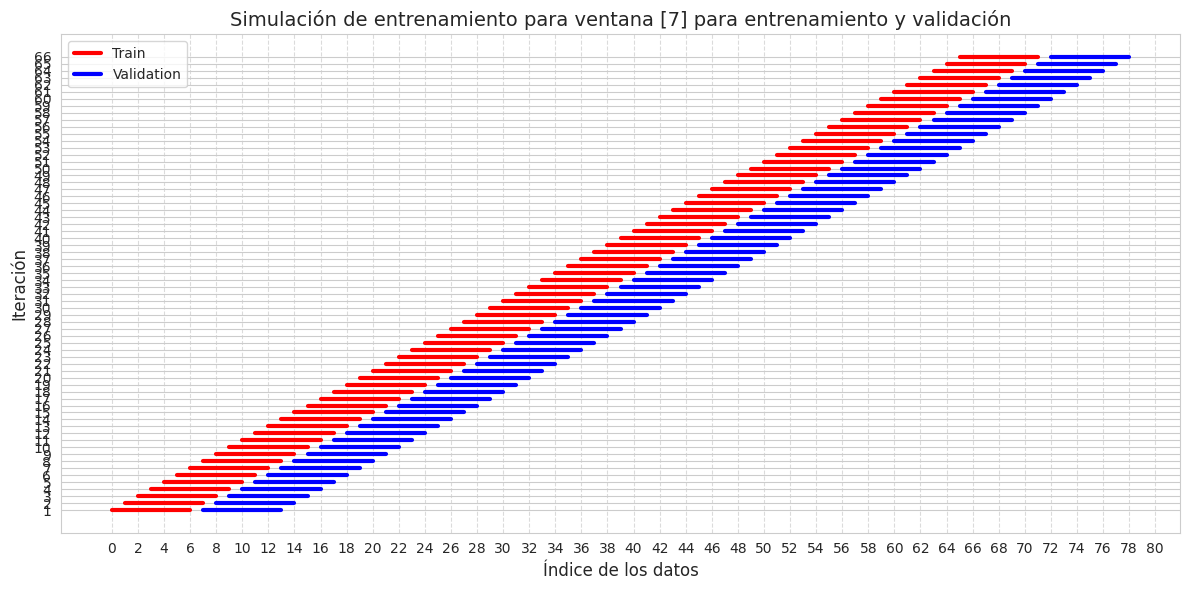

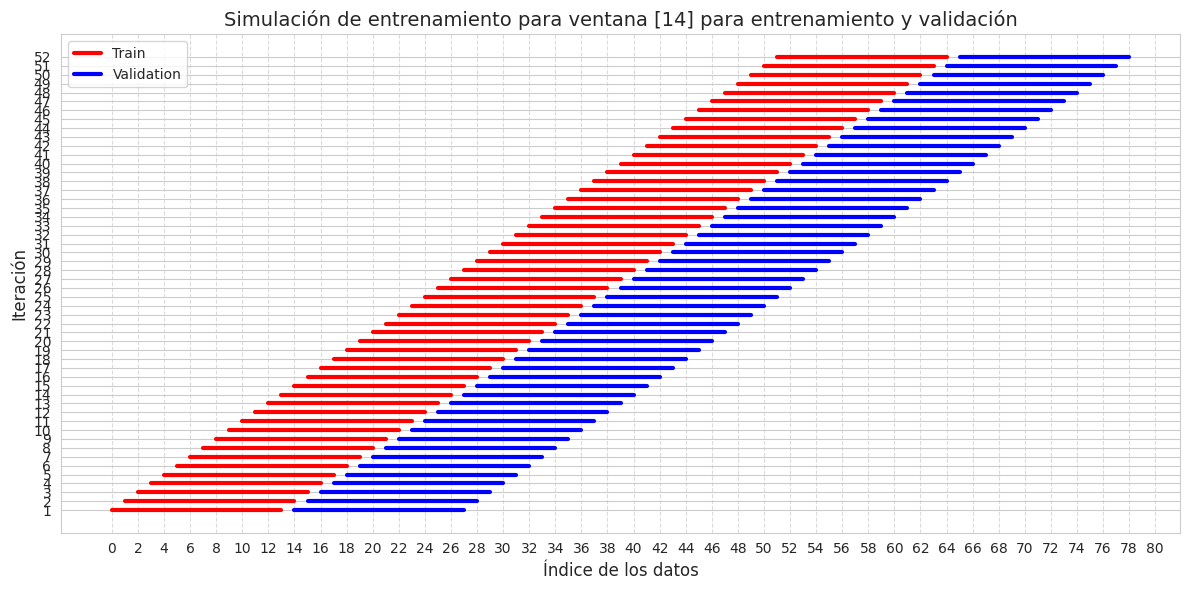

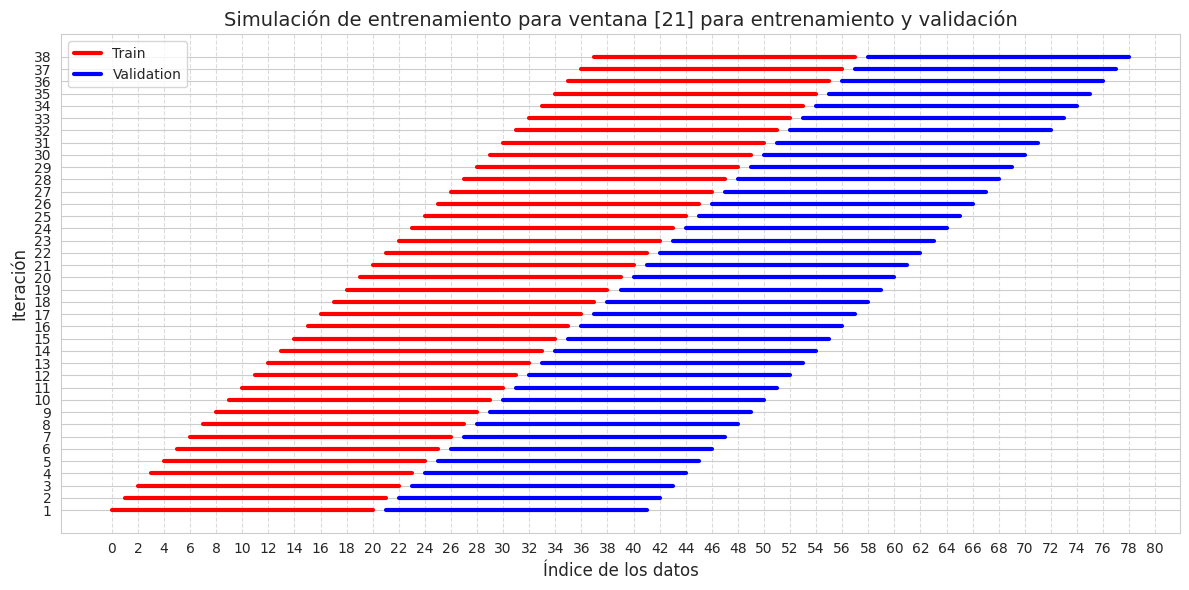

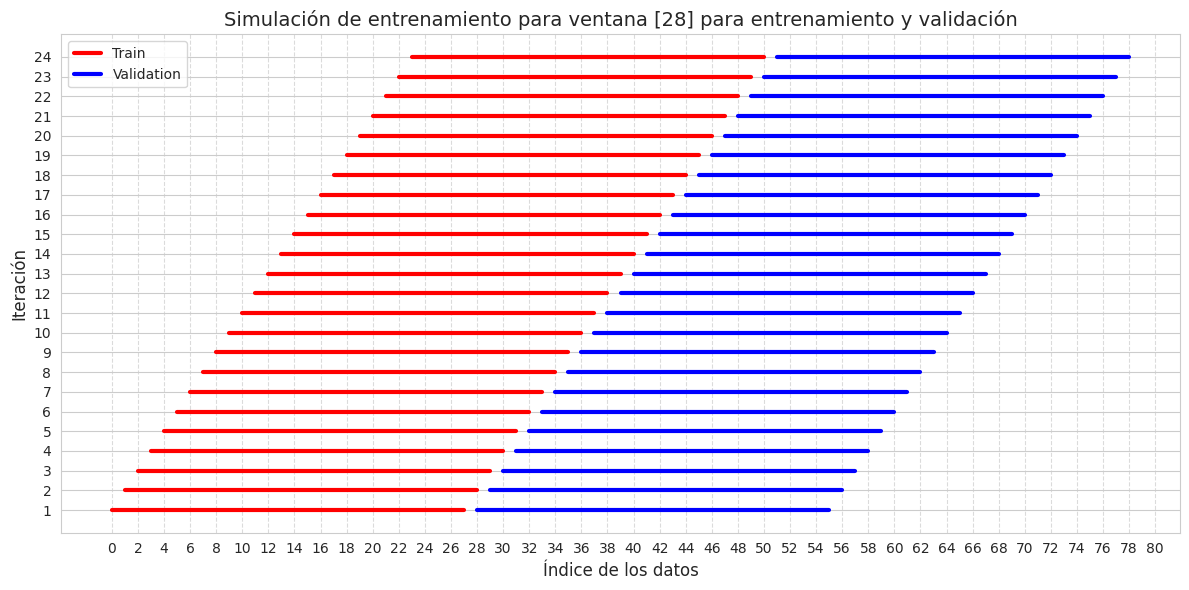

In [13]:
for window  in [7, 14, 21, 28]:
    total_points = 80
    train_window = window
    val_window = window
    stride = 1

    train_positions = []
    val_positions = []

    for start in range(0, total_points - train_window - val_window, stride):
        train_positions.append(range(start, start + train_window))
        val_positions.append(range(start + train_window, start + train_window + val_window))

    plt.figure(figsize=(12, 6))
    for i, (train, val) in enumerate(zip(train_positions, val_positions)):
        plt.plot(train, [i + 1] * len(train), 'r-', label='Train' if i == 0 else "", linewidth=3)
        plt.plot(val, [i + 1] * len(val), 'b-', label='Validation' if i == 0 else "", linewidth=3)

    plt.title(f"Simulación de entrenamiento para ventana [{window}] para entrenamiento y validación", fontsize=14)
    plt.xlabel("Índice de los datos", fontsize=12)
    plt.ylabel("Iteración", fontsize=12)
    plt.xticks(range(0, total_points + 1, 2))
    plt.yticks(range(1, len(train_positions) + 1))
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()